In [1]:
import os
GPU_id = 3
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import sys
sys.path.insert(1, '../')

In [3]:
import torch
import pandas as pd
import numpy as np
from time import time 
# from ds_itr.adamw import AdamW as AW

import fastai
from fastai import *
from fastai.basic_data import *
from fastai.basic_data import *
from fastai.tabular import *
from fastai.basic_data import DataBunch
from fastai.tabular import TabularModel

import cudf

import nv_tabular as nvt
from nv_tabular.ops import Normalize, FillMissing, Categorify, Moments, Median, Encoder, LogOp, ZeroFill
from nv_tabular.batchloader import TensorItrDataset, FileItrDataset, DLCollator, DLDataLoader

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [4]:
torch.__version__, cudf.__version__, fastai.__version__

('1.5.0.dev20200304', '0.13.0a+3190.gac8aabfee', '1.0.60')

In [5]:
%load_ext snakeviz
# load snakeviz if you want to run profiling

In [6]:
# to_cpu = True

In [7]:
import datetime
datafolder = '/datasets/rossmann/'


In [8]:
# traindf = pd.read_csv(f'{datafolder}/train.csv', low_memory=False)
# testdf = pd.read_csv(f'{datafolder}/test.csv', low_memory=False)
# storedf = pd.read_csv(f'{datafolder}/store.csv', low_memory=False)
# print("Preprocessing...")

categorical_cols = [
    'Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'Week', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
    'Promo2SinceYear', 'PromoInterval',
]
continuous_cols = [
    'CompetitionDistance'
]
# traindf = traindf.drop(['Customers', 'Open'], axis=1)
# testdf = testdf.drop(['Open', 'Id'], axis=1)

# def modify_df(df):
#     initlen = len(df)

#     # Expand date into [Year, Month, Day, Week]
#     df.Date = pd.to_datetime(df.Date)
#     for attr in ['Year', 'Month', 'Day', 'Week']:
#         df[attr] = getattr(pd.DatetimeIndex(df.Date), attr.lower())

#     # Join store.csv and train/test.csv on Store
#     df = pd.merge(df, storedf, on='Store')

#     # Fix NaNs in *Since* columns
#     defaults = {'CompetitionOpenSinceYear': 1900, 'CompetitionOpenSinceMonth': 1,
#                 'Promo2SinceYear': 1900, 'Promo2SinceWeek': 1, 'CompetitionDistance': 0}
#     df = df.fillna(defaults)

#     # Ensure no rows lost on the join
#     assert len(df) == initlen

#     # Cast continuous columns to float
#     df = df.astype({x: 'float32' for x in continuous_cols})

#     # StateHoliday is a special case
#     df.StateHoliday = df.StateHoliday.astype(str).replace("0", "d")

#     # Move the continuous columns to the end
#     for column in continuous_cols:
#         cd = df.pop(column)
#         df[column] = cd
#     return df

# traindf = modify_df(traindf)
# testdf = modify_df(testdf)

# # Filter out 0 sales from train
# traindf = traindf[traindf.Sales > 0]

# # Index categorical columns across both train and test.
# for col in categorical_cols:
#     # Get the default type for the column
#     default_type = traindf[col].dtype.type() if traindf[col].dtype.type() is not None else ''
#     # Fix NaNs with the default value for the column's type.
#     traindf[col] = traindf[col].fillna(default_type)
#     testdf[col] = testdf[col].fillna(default_type)

# # Move the sales column to the end
# sales = traindf.pop('Sales')
# traindf['Sales'] = sales

# # Make a validation set from the equivalent period of the test set in the training set, a year before.
# t0 = testdf.Date.min() - datetime.timedelta(365)
# t1 = testdf.Date.max() - datetime.timedelta(365)
# val_mask = (traindf.Date > t0) & (traindf.Date <= t1)
# valdf, traindf = traindf[val_mask], traindf[~val_mask]

# # Drop unnecessary columns
# traindf = traindf.drop('Date', axis=1)
# valdf = valdf.drop('Date', axis=1)
# testdf = testdf.drop('Date', axis=1)

# print("Saving to file...")
# traindf.to_csv(f'{datafolder}/train_fin.csv', index=False)
# testdf.to_csv(f'{datafolder}/test_fin.csv', index=False)
# valdf.to_csv(f'{datafolder}/val_fin.csv', index=False)

# print("Done.")

In [9]:
# traindf.describe()

<h3> Dataset Gathering: Define files in the training and validation datasets. </h3>

In [10]:
train_set = os.path.join(datafolder , 'train_fin.csv')
valid_set = [datafolder + 'val_fin.csv']

In [11]:
check = cudf.read_csv(train_set)

In [12]:
cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year',
       'Month', 'Day', 'Week', 'StoreType', 'Assortment',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionDistance', 'Sales']

<h4>Grab column information</h4>

In [13]:
cat_names = [
        'Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'Week', 'Promo', 'StateHoliday', 'SchoolHoliday',
        'StoreType', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Assortment',
        'Promo2SinceYear', 'PromoInterval',
    ]
cont_names = [
        'CompetitionDistance'
    ] 
cat_names = [name for name in cat_names if name in cols]
cont_names = [name for name in cont_names if name in cols]


<h3>Preprocessing:</h3> <p>Select operations to perform, create the Preprocessor object, create dataset iterator object and collect the stats on the training dataset</p>

In [14]:
%%time
proc = nvt.Workflow(cat_names=cat_names, cont_names=cont_names, label_name=['Sales'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 74.4 µs


In [15]:
proc.add_cont_feature(FillMissing())
proc.add_cont_preprocess(Normalize())
proc.add_cat_preprocess(Categorify())

In [16]:
%%time
trains_itrs = nvt.dataset(train_set,names=cols, engine='csv')
valid_itrs = nvt.dataset(valid_set, names=cols, engine='csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.9 µs


In [17]:
output_path_train = './jp_ross/train'
output_path_valid = './jp_ross/valid'

In [18]:
%%time
proc.apply(trains_itrs, apply_offline=True, record_stats=True, output_path=output_path_train, shuffle=False)

CPU times: user 2.25 s, sys: 1.96 s, total: 4.2 s
Wall time: 4.53 s


In [19]:
%%time
proc.apply(valid_itrs, apply_offline=True, record_stats=False, output_path=output_path_valid, shuffle=False)

CPU times: user 920 ms, sys: 88 ms, total: 1.01 s
Wall time: 1.03 s


In [20]:
proc.create_final_cols()

<h5>Gather embeddings using statistics gathered in the Read phase.</h5>

In [21]:
embeddings = [x[1] for x in proc.df_ops['Categorify'].get_emb_sz(proc.stats["categories"], proc.columns_ctx["categorical"]['base'])]

In [22]:
embeddings

[(5, 4),
 (14, 7),
 (25, 10),
 (33, 11),
 (9, 5),
 (14, 7),
 (4, 3),
 (4, 3),
 (26, 10),
 (10, 6),
 (5, 4),
 (4, 3),
 (6, 4),
 (1117, 16),
 (6, 4),
 (54, 15),
 (5, 4)]

In [29]:
new_train_set = [os.path.join(output_path_train, x) for x in os.listdir(output_path_train) if x.endswith("parquet")]
new_valid_set = [os.path.join(output_path_valid, x) for x in os.listdir(output_path_valid) if x.endswith("parquet")]

In [30]:
new_valids_itr = nvt.dataset(new_valid_set)
new_trains_itr = nvt.dataset(new_train_set)

<h5>Create the file iterators using the FileItrDataset Class.</h5>

In [31]:
train_xy = proc.ds_to_tensors(new_trains_itr, apply_ops=False)
val_xy = proc.ds_to_tensors(new_trains_itr, apply_ops=False)


In [32]:
%%time
t_sets = [train_xy[0], train_xy[1], train_xy[2]]
v_sets = [val_xy[0], val_xy[1], val_xy[2]]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs


In [33]:
t_batch_sets = [TensorItrDataset(t_sets, batch_size=1024) for i in range(10)]
v_batch_sets = [TensorItrDataset(v_sets, batch_size=1024) for i in range(10)]

In [34]:
%%time
t_chain = torch.utils.data.ChainDataset(t_batch_sets)
v_chain = torch.utils.data.ChainDataset(v_batch_sets)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.7 µs


<h5>Use the Deep Learning Collator to create a collate function to pass to the dataloader.</h5>

In [35]:
def gen_col(batch):
    batch = batch[0]
    return batch[0], batch[1].long()

In [36]:
%%time
t_data = DLDataLoader(t_chain, collate_fn=gen_col, pin_memory=False, num_workers=0)
v_data = DLDataLoader(v_chain, collate_fn=gen_col, pin_memory=False, num_workers=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 147 µs


<h4>After creating the Dataloaders you can leverage fastai framework to create Machine Learning models</h4>

In [37]:
databunch = DataBunch(t_data, v_data, collate_fn=gen_col, device="cuda")

In [38]:
%%time

model = TabularModel(emb_szs = embeddings, n_cont=len(cont_names), out_sz=1, layers=[1000,500])

learn =  Learner(databunch, model)
learn.loss_func = MSELossFlat()
# learn.opt_func = AW
learn.lr_find()


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 1.88 s, sys: 248 ms, total: 2.13 s
Wall time: 2.17 s


Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.31E-01


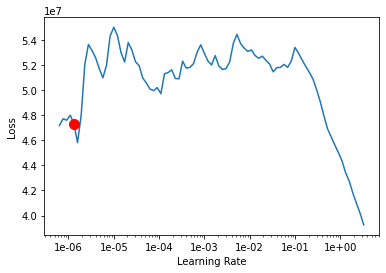

In [39]:
learn.recorder.plot(show_moms=True, suggestion=True)

In [40]:
learning_rate = 2.75-2
epochs = 10

In [41]:
start = time()
learn.fit(epochs,learning_rate)
t_final = time() - start 

epoch,train_loss,valid_loss,time
0,9645057.000000,14650407.000000,02:01
1,9630879.000000,34182476.000000,02:02
2,9711946.000000,16843962.000000,02:02
3,9723174.000000,12550950.000000,02:04
4,9675789.000000,17316290.000000,02:01
5,9711494.000000,15335508.000000,02:02
6,9598784.000000,44967132.000000,02:04
7,9706428.000000,27885048.000000,02:03
8,9620242.000000,7341233664.000000,02:02
9,9583253.000000,62008606720.000000,02:06


In [ ]:
del learn 
del model
del databunch
torch.cuda.empty_cache() 

In [ ]:
t_final